# Build a brain model for decilitated cell

In [1]:
from brian2 import *
from brian2tools import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [2]:
import numpy as np
import pandas as pd

In [3]:
dt = 5e-05 * second
dt

50. * usecond

## Load the data

In [4]:
df_v = pd.read_csv('decilliated_v_pos.csv')
df_ic = pd.read_csv('decilliated_ic_pos.csv')
df_inoise = pd.read_csv('decilliated_i_noise.csv')
df_wn_v = pd.read_csv('decilliated_v_noise.csv')

#### Get V positive

In [5]:
Vout = df_v.to_numpy()
Vout = Vout[:, 2:]

In [6]:
np.shape(Vout)

(20, 22399)

In [7]:
Vout

array([[-0.02855869, -0.02865738, -0.02878897, ..., -0.02867383,
        -0.02862449, -0.02865738],
       [-0.02873963, -0.02862449, -0.02873963, ..., -0.02609142,
        -0.0263217 , -0.02602562],
       [-0.02829552, -0.02832841, -0.02803234, ..., -0.02829552,
        -0.02827907, -0.02844355],
       ...,
       [-0.02564731, -0.02572955, -0.0257131 , ..., -0.02423274,
        -0.02424918, -0.02433143],
       [-0.02439722, -0.02418339, -0.02428208, ..., -0.02276882,
        -0.02257144, -0.02270302],
       [-0.02135425, -0.02138714, -0.02122266, ..., -0.02329517,
        -0.02314713, -0.02311424]])

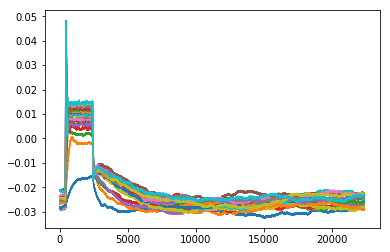

In [8]:
plot(Vout.transpose());

#### Get positive injection current

In [9]:
Ic = df_ic.to_numpy()
Ic = Ic[:, 1:]

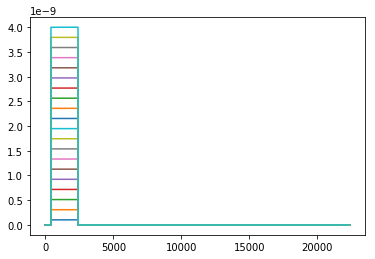

In [10]:
plot(Ic.transpose());

#### Get white noise injection

In [11]:
Inoise = df_inoise.to_numpy()
Inoise = Inoise[:, 1:].transpose()[0]

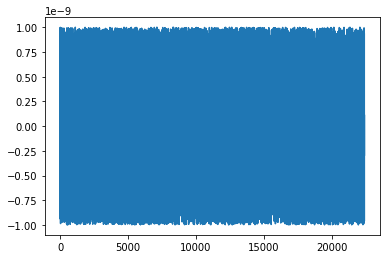

In [12]:
plot(Inoise);

#### Get V from white noise

In [13]:
Vnoise = df_wn_v.to_numpy()
Vnoise

array([[ 0.00000000e+00, -2.14199251e-02],
       [ 1.00000000e+00, -2.11783904e-02],
       [ 2.00000000e+00, -1.81857748e-02],
       ...,
       [ 2.23970000e+04, -1.97739284e-02],
       [ 2.23980000e+04, -2.02280022e-02],
       [ 2.23990000e+04, -2.24099003e-02]])

In [14]:
Vnoise = Vnoise[1:, 1:].transpose()[0]
Vnoise

array([-0.02117839, -0.01818577, -0.01544201, ..., -0.01977393,
       -0.020228  , -0.0224099 ])

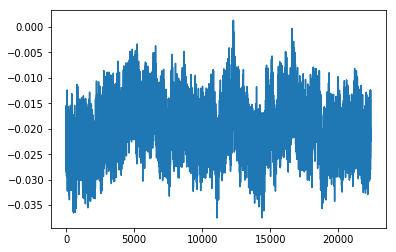

In [15]:
plot(Vnoise);

### Concatinate the data

In [16]:
np.shape(Vnoise[:10000])

(10000,)

In [17]:
np.shape(Vout[:, :10000])

(20, 10000)

In [18]:
output = np.concatenate((Vout[:, :10000], [Vnoise[:10000]]))
np.shape(output)

(21, 10000)

In [19]:
input_cur = np.concatenate((Ic[:,:10000], [Inoise[:10000]]))
np.shape(input_cur)

(21, 10000)

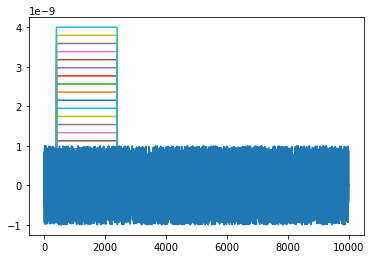

In [20]:
plot(input_cur.transpose());

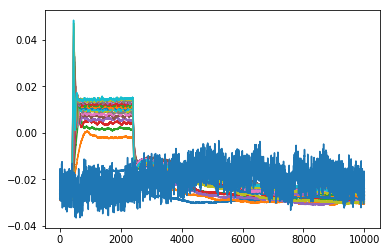

In [21]:
plot(output.transpose());

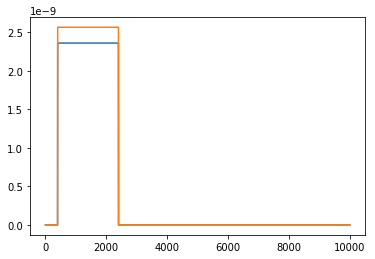

In [22]:
plot(input_cur[11:13].transpose())

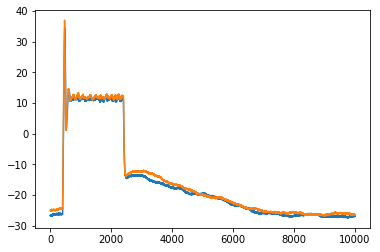

In [23]:
plot((output[11:13]/1e-3).transpose());

## Build a model

In [24]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*n*(Ek - v) + I(t))/C : volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
''',
# C = 130*pF,
C = 300*pF,
EL = -30*mV,
gL = 1/50*1/Mohm)
# gL = 1/142*1/Mohm)

In [25]:
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
I = TimedArray(input_current0, dt=dt)

In [26]:
G = NeuronGroup(1, model, method='exponential_euler')
G.set_states({'g_k': 1, 'kn': 1, 'taun': 1, 'Vn': 1, 'Ek': 1}, units=False)
run(10*ms)

In [27]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*(n**4)*(Ek - v) + I)/C : volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
''',
C = 300*pF,
EL = -30*mV,
gL = 1/50*1/Mohm)

In [28]:
start_scope()
n_opt = NevergradOptimizer(method='DE')
# n_opt = SkoptOptimizer()
metric = MSEMetric()

res, error = fit_traces(model=model, input_var='I', output_var='v',
                        input=input_cur[11:13] * amp, output=output[11:13] * volt, dt=dt,
                        method='exponential_euler',
                        g_k=[10e-3*siemens, 10e2*siemens],
                        kn = [5*mV, 20*mV],
                        Vn = [-20*mV, 20*mV],
                        Ek = [-100*mV, 0*mV],
                        taun=[10e-2*ms, 100*ms],
                        param_init={'v': -30 * mV},
                        n_rounds=1, n_samples=30, optimizer=n_opt, metric=None)

round 0 with error 0.00020371839481809204
parameters: {'g_k': 775.0425708052342, 'taun': 0.024616487870554284, 'kn': 0.01546174490596519, 'Ek': -0.016774965840634454, 'Vn': 0.015054912362136625}


In [29]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*(n**4)*(Ek - v) + I)/C : volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
C: farad (constant)
EL: volt (constant)
gL: siemens (constant)
''',
# C = 300*pF,
# EL = -30*mV,
# gL = 1/50*1/Mohm
)

In [30]:
start_scope()
n_opt = NevergradOptimizer(method='DE')
# n_opt = SkoptOptimizer()
metric = MSEMetric()


In [31]:
def callback(res, errors, parameters, index):
    print('index {} errors minimum: {}'.format(index, min(errors)) )

In [32]:
# set_device('cpp_standalone', directory='parallel', clean=False)

In [33]:
res, error = fit_traces(model=model, input_var='I', output_var='v',
                        input=input_cur * amp, output=output * volt, dt=dt,
                        method='exponential_euler',
                        callback=callback,
                        EL=[-50*mV, -10*mV],
                        C=[100*pF, 400*pF],
                        gL=[7*nS, 20*nS],                        
                        kn=[5*mV, 20*mV],
                        Vn=[-20*mV, 20*mV],
                        Ek=[-100*mV, 0*mV],
                        g_k=[1e-2*uS, 1e2*uS],
                        taun=[0.1*ms, 40*ms],
                        param_init={'v': -30 * mV},
                        n_rounds=20, n_samples=30, optimizer=n_opt, metric=None)

index 0 errors minimum: 6.525042711956335e-05
index 1 errors minimum: 3.4455120502148476e-05
index 2 errors minimum: 2.9088324950585076e-05
index 3 errors minimum: 2.189822280915387e-05
index 4 errors minimum: 2.4505447035910944e-05
index 5 errors minimum: 2.0800789918255495e-05
index 6 errors minimum: 2.0171633260419563e-05
index 7 errors minimum: 1.8235232340559265e-05
index 8 errors minimum: 1.7951684602424878e-05
index 9 errors minimum: 1.7320418584859374e-05
index 10 errors minimum: 1.8462322844104776e-05
index 11 errors minimum: 1.684111715215955e-05
index 12 errors minimum: 1.7298479289704512e-05
index 13 errors minimum: 1.684111715215955e-05
index 14 errors minimum: 1.7526147224977792e-05
index 15 errors minimum: 1.6990540756648103e-05
index 16 errors minimum: 1.6591842229931126e-05
index 17 errors minimum: 1.666432213406124e-05
index 18 errors minimum: 1.6446910428618232e-05
index 19 errors minimum: 1.6522059909978303e-05


In [34]:
res

{'C': 1.4357033494723357e-10,
 'g_k': 1.0328444476948011e-05,
 'taun': 0.0028861484920472136,
 'gL': 9.094731826168789e-09,
 'kn': 0.010093667173780144,
 'EL': -0.023010058378536435,
 'Ek': -0.00926047852886959,
 'Vn': 0.017739947955966926}

In [35]:
print('g_k', res['g_k']*siemens)
print('taun', res['taun']*second)

g_k 10.32844448 uS
taun 2.88614849 ms


In [36]:
print('Ek', res['Ek']*volt)
print('C', res['C']*farad)
print('EL', res['EL']*volt)
print('gL', res['gL']*siemens)
print('Vn', res['Vn']*volt)
print('kn', res['kn']*volt)

Ek -9.26047853 mV
C 143.57033495 pF
EL -23.01005838 mV
gL 9.09473183 nS
Vn 17.73994796 mV
kn 10.09366717 mV


In [49]:
# visualization of the results
start_scope()
fits = generate_fits(model=model, method='exponential_euler', params=res,
                     input=input_cur * amp, input_var='I', output_var='v',
                     param_init={'v': -30 * mV},
                     dt=dt)

fits/mV

array([[-30.        , -29.97789548, -29.95586086, ..., -23.00864574,
        -23.00864574, -23.00864574],
       [-30.        , -29.97789548, -29.95586086, ..., -23.00864574,
        -23.00864574, -23.00864574],
       [-30.        , -29.97789548, -29.95586086, ..., -23.00864574,
        -23.00864574, -23.00864574],
       ...,
       [-30.        , -29.97789548, -29.95586086, ..., -23.00864574,
        -23.00864574, -23.00864574],
       [-30.        , -29.97789548, -29.95586086, ..., -23.00864574,
        -23.00864574, -23.00864574],
       [-30.        , -29.68620477, -29.48292764, ..., -23.67871442,
        -23.80875657, -23.50255497]])

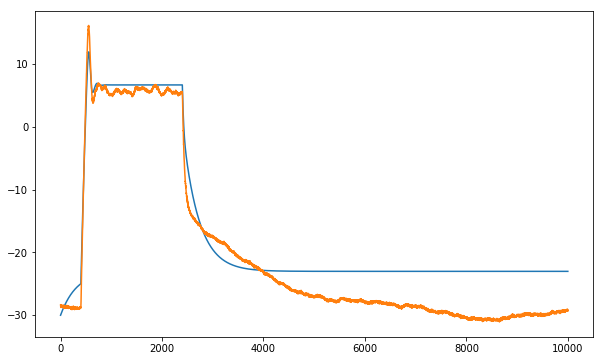

In [50]:
d = 4
plt.figure(figsize=(10,6))
plot(fits[d]/mV)
plot(output[d]/1e-3);

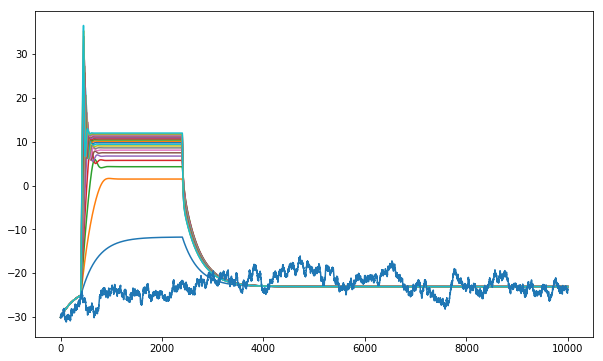

In [51]:
plt.figure(figsize=(10,6))
plot((fits/mV).transpose());

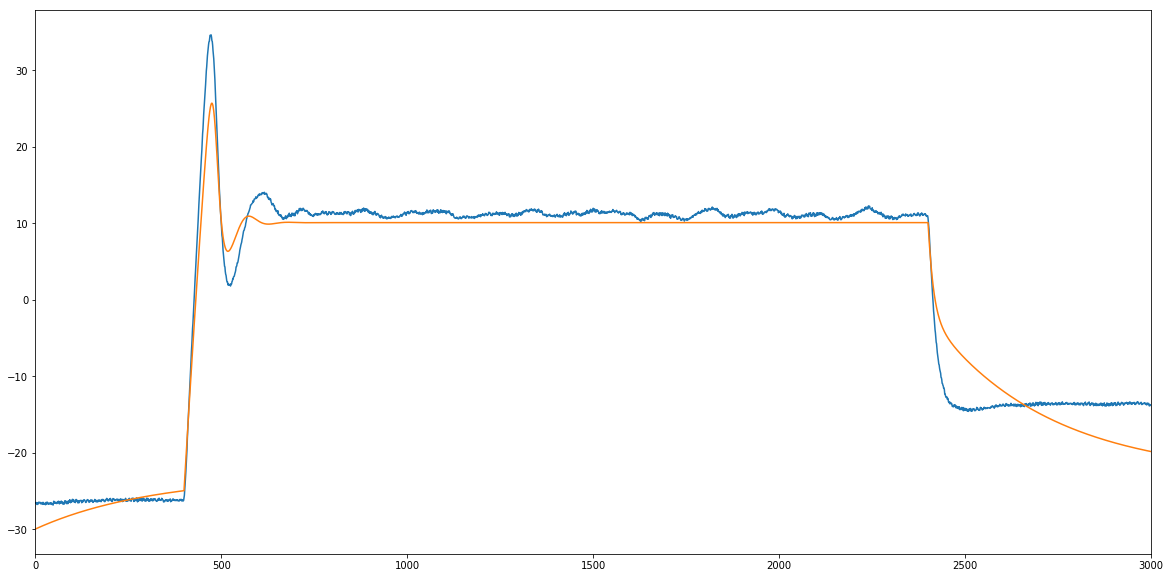

In [52]:
plt.figure(figsize=(20,10))
# plt.ylim(-10,40)
plt.xlim(0,3000)
plot((output[11]/1e-3).transpose());
plot((fits[11]/mV).transpose());

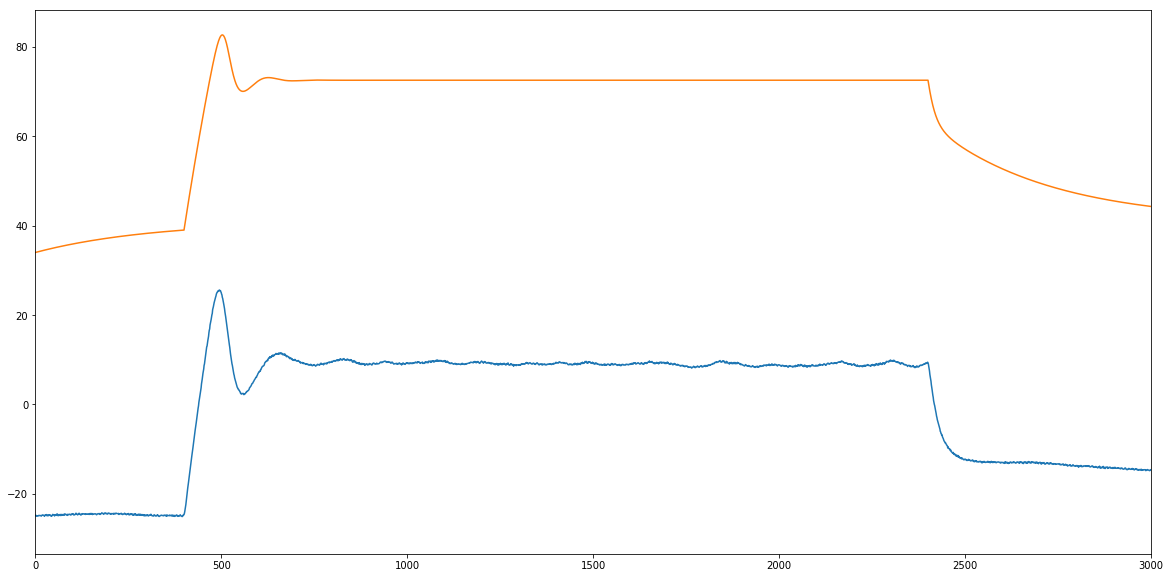

In [53]:
d=7
plt.figure(figsize=(20,10))
# plt.ylim(-10,40)
plt.xlim(0,3000)
plot((output[d]/1e-3).transpose());
plot((fits[d]/mV+64).transpose());

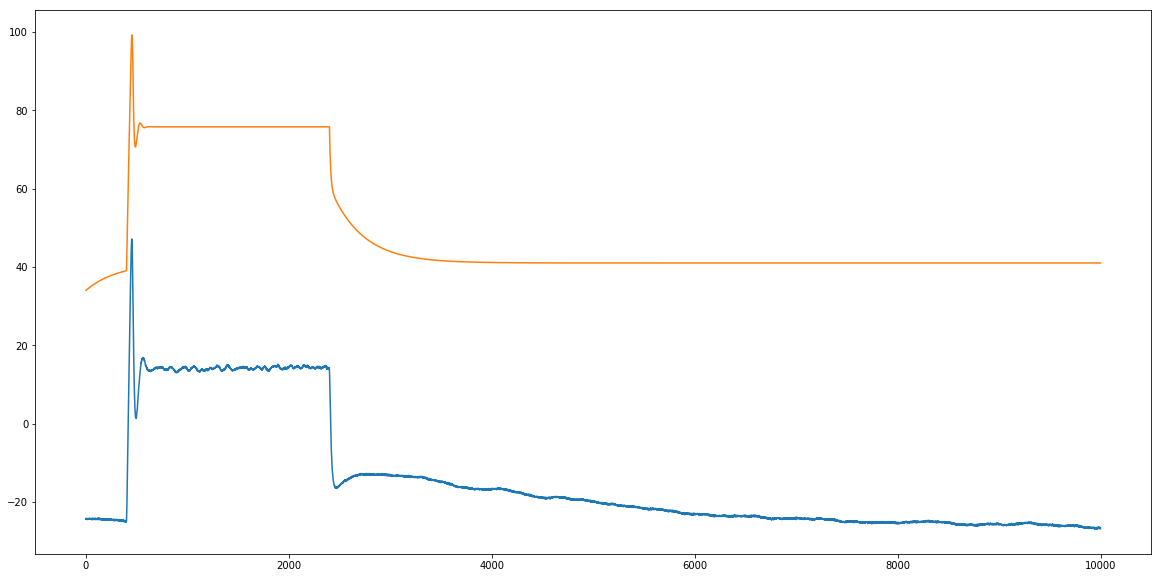

In [54]:
d=18
plt.figure(figsize=(20,10))
# plt.ylim(-10,40)
# plt.xlim(0,3000)
plot((output[d]/1e-3).transpose());
plot((fits[d]/mV+64).transpose());

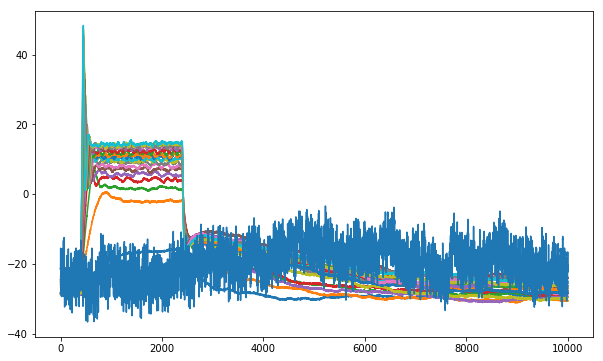

In [59]:
plt.figure(figsize=(10,6))
plot((output/1e-3).transpose());

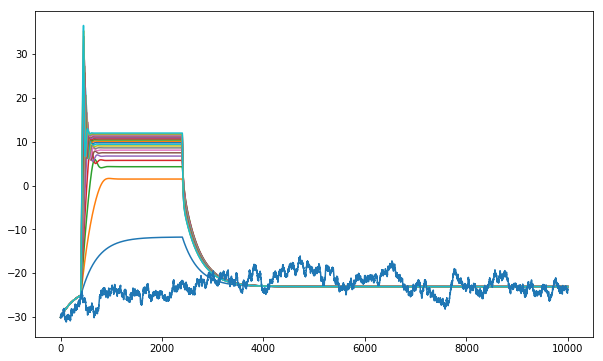

In [58]:
plt.figure(figsize=(10,6))
plot((fits/mV).transpose());